## Geo classification

Divide tweets based on their geographic location and perform stance analysis per group.

In [1]:
import ast
import fasttext
import os
import pandas as pd
import re
import sys

from IPython.display import clear_output
from nltk.tokenize import TweetTokenizer

In [17]:
BELGIUM = "Belgium"
BESTDIM = 200
BESTEPOCH = 200
BESTLR = 0.2
DATE = "date"
DISTANCE = "distance"
FACEMASK = "mondkapje"
IRRELEVANT = "IRRELEVANT"
MONTH = "202006"
NETHERLANDS = "Netherlands"
MAXDAYSPERMONTH = 31
QUERYDISTANCE = "1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"
QUERYFACEMASK = FACEMASK
NIELSEN = "nielsen"
SCREENNAME = "screenname"
TEXT = "text"
TEXTDATADIRECTORY = "../data/text/"
TOPIC = DISTANCE
TOTAL = "total"
USER = "user"

LOCATIONFILE = F"locations-{MONTH}.csv"
MODELFILE = f"model-{TOPIC}-{BESTDIM}-{BESTEPOCH}-{BESTLR}.bin"

In [3]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)
        
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)

def tokenize(text):
    return(" ".join(TweetTokenizer().tokenize(text)))

def preprocess(text):
    return(tokenize(cleanup(text)).lower())

def selectBelgiumNetherlands(locationDf,locationFile):
    locationsDict = { locationsDf.index[i]:locationsDf.iloc[i] for i in range(0,len(locationsDf)) \
                      if re.search(f"{BELGIUM}|{NETHERLANDS}",locationsDf.iloc[i][NIELSEN]) }
    pd.DataFrame(locationsDict).T.to_csv(locationFile,index_label=SCREENNAME)

def readDataGeo(datePattern,query,locationsDf,dataDirectory=TEXTDATADIRECTORY):
    fileList = sorted(os.listdir(dataDirectory))
    testData = {}
    for inFileName in fileList:
        if re.search(datePattern,inFileName) and os.path.exists(dataDirectory+inFileName):
            squeal(inFileName)
            try:
                fileData = pd.read_csv(dataDirectory+inFileName).drop_duplicates()
                for i in range(0,len(fileData)):
                    user = fileData.iloc[i][USER]
                    if user in locationsDf.index:
                        nielsen = locationsDf.loc[user][NIELSEN]
                        if not nielsen in testData: testData[nielsen] = []
                        testData[nielsen].append(preprocess(fileData.iloc[i][TEXT]))
            except:
                pass
    return(testData)

def classifyGeo(datePattern,query,model,locationsDf,dataDirectory=TEXTDATADIRECTORY):
    labelPercentages = {}
    testData = readDataGeo(datePattern,query,locationsDf,dataDirectory)
    for location in testData:
        predictedLabels = model.predict(testData[location])
        predictedGroups = pd.DataFrame(predictedLabels[0]).groupby(0).groups
        labelCountsPredicted = {label:len(predictedGroups[label]) for label in predictedGroups}
        nbrOfLabels = sum([labelCountsPredicted[label] for label in labelCountsPredicted if label != IRRELEVANT])
        labelPercentages[location] = { label:round(100*labelCountsPredicted[label]/nbrOfLabels,1) for label in labelCountsPredicted}
        labelPercentages[location][TOTAL] = nbrOfLabels
    return(labelPercentages)

In [4]:
locationsDf = pd.read_csv(LOCATIONFILE,index_col=SCREENNAME)
fastTextModel = fasttext.load_model(MODELFILE)
#selectBelgiumNetherlands(locationsDf,LOCATIONFILE)

### (time-consuming...)

In [5]:
results = {}
for month in MONTH.split():
    for day in range(1,MAXDAYSPERMONTH+1):
        date = month+str(day).zfill(2)
        results[date] = classifyGeo(date,QUERYDISTANCE,fastTextModel,locationsDf)

20200731-23.out.gz


In [7]:
pd.DataFrame(results).T.to_csv(f"results-{TOPIC}-{MONTH}.csv",index_label=DATE)

## Visualization

In [8]:
import datetime
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [15]:
DATEFORMAT = "%Y%m%d"
SUPPORTS = "__label__SUPPORTS"
REJECTS = "__label__REJECTS"
PLOTFILENAME = f"stance-{DISTANCE}-geo.png"
WEEKLENGTH = 7

In [14]:
def movingAverage(numberList,size):
    newList = []
    for i in range(0,len(numberList)):
        numberUsed = 1
        newList.append(numberList[i])
        for j in range(1,size):
            if i-j >= 0:
                newList[i] += numberList[i-j]
                numberUsed += 1
        newList[i] /= numberUsed
    return(newList)

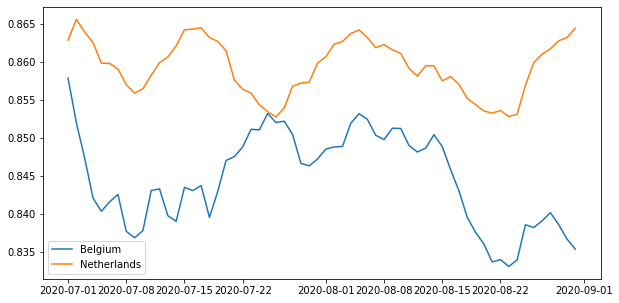

In [16]:
results = {}
for month in "202006 202007 202008".split():
    resultsDf = pd.read_csv(f"results-{TOPIC}-{month}.csv",index_col=DATE)
    results = {**results,**(resultsDf.T.to_dict())}

for date in sorted(results.keys()):
    toBeDeleted = []
    for nielsen in results[date].keys():
        try:
            results[date][nielsen] = ast.literal_eval(results[date][nielsen])
        except:
            toBeDeleted.append((date,nielsen))
    for date,nielsen in toBeDeleted: del(results[date][nielsen])

for date in sorted(results.keys()):
    for country in [BELGIUM,NETHERLANDS]:
        if not country in results[date]: results[date][country] = {}
        for nielsen in results[date].keys():
            if nielsen != country and re.search(country,nielsen):
                for label in results[date][nielsen]:
                    if label != TOTAL:
                        if not label in results[date][country]: results[date][country][label] = 0
                        results[date][country][label] = (results[date][country][label]*results[date][country][TOTAL]+\
                                                         results[date][nielsen][label]*results[date][nielsen][TOTAL])/\
                                                        (results[date][country][TOTAL]+results[date][nielsen][TOTAL])
                for label in results[date][nielsen]:
                    results[date][BELGIUM][TOTAL] += results[date][nielsen][TOTAL]
        
x = {}
y = {}
for date in sorted(results.keys()):
    for nielsen in sorted(results[date].keys()):
        if not re.search(NIELSEN,nielsen.lower()):
            if not SUPPORTS in results[date][nielsen]: results[date][nielsen][SUPPORTS] = 0.0
            if not REJECTS in results[date][nielsen]: results[date][nielsen][REJECTS] = 0.0
            if results[date][nielsen][SUPPORTS] + results[date][nielsen][REJECTS] > 0:
                if not nielsen in x:
                    x[nielsen] = []
                    y[nielsen] = []
                x[nielsen].append(datetime.datetime.strptime(str(date),DATEFORMAT))
                y[nielsen].append(results[date][nielsen][SUPPORTS]/(results[date][nielsen][SUPPORTS]+results[date][nielsen][REJECTS]))

plt.figure(figsize=(10,5))
for nielsen in x:
    plt.plot_date(x[nielsen],movingAverage(y[nielsen],WEEKLENGTH),fmt="-",label=nielsen)
plt.legend()
plt.savefig(PLOTFILENAME)
plt.show()

## Sandbox